# PROJECT: PARTICLE DETECTOR DATA ANALYSIS
### Dataset: Run330, Physics Run

<a id =6></a><br>
The same code is applied to the physics run. The description of these codes, however, are in the calibration run notebook. In this notebook, we show the main differences between the calibration run and the physics run. The highlights are linked below.
 
 - [HISTOGRAM OF HITS PER CHANNEL](#1)
 
 - [EVENTS OF PHYSICS RUN](#2)
 
 - [DISTRIBUTION OF DRIFT TIMES](#3)
 
 - [RATIO OF USEFUL EVENTS](#5)
 
 - [DETECTOR MATRIX](#4)
 
 

In [1]:
# Important imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from os import listdir
from os.path import isfile, join, getsize
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string)) # for markdown purposes
from numba import vectorize, int64, int32, jit, njit, cuda, float64

***

# I. THE DATA
[Content Outline](#6)

In [2]:
# Set as True for Physics run 
REAL_DATA = True

# Limit the amount of data we are accepting 
if REAL_DATA == True:
    mypath = 'data/Run000333/'
else:
    mypath = 'data/Run000260/'

max_mb = 256 # maximum size of data in mb to read
files = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
mb = 0
for i in range(len(files)):
    mb += getsize(files[i])/1024**2 # getsize returns size in bytes
    if mb >= max_mb:
        files = files[:(i-1)]
        break

# Concatenate the files and load the data
data = pd.concat([pd.read_csv(file) for file in files], axis = 0)
data.reset_index(inplace=True, drop=True) #This resets the index from 0 to onwards
# data = pd.read_csv(files[0])

# Drop the 'HEAD' column
data.drop('HEAD', inplace=True, axis=1) # We remove the 'HEAD', inplace = True because we return nothing

# Print the description of the data
printmd('## DESCRIPTION OF THE DATA')
print('Files concatenated:', '\n', files, '\n') # To check which files are read
print(data.info())
# display(data.describe())

#Visualize the first 10 entries of the file
printmd('## THE DATAFRAME')
printmd('The dataframe below presents the first 10 hits as presented in the raw data.')
display(data.head(10))

## DESCRIPTION OF THE DATA

Files concatenated: 
 ['data/Run000333/data_000000.txt', 'data/Run000333/data_000001.txt', 'data/Run000333/data_000002.txt', 'data/Run000333/data_000003.txt', 'data/Run000333/data_000004.txt', 'data/Run000333/data_000005.txt', 'data/Run000333/data_000006.txt'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9174912 entries, 0 to 9174911
Data columns (total 5 columns):
 #   Column       Dtype
---  ------       -----
 0   FPGA         int64
 1   TDC_CHANNEL  int64
 2   ORBIT_CNT    int64
 3   BX_COUNTER   int64
 4   TDC_MEAS     int64
dtypes: int64(5)
memory usage: 350.0 MB
None


## THE DATAFRAME

The dataframe below presents the first 10 hits as presented in the raw data.

,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,4,3838279555,2703,1
1,0,62,3838279555,2695,25
2,1,12,3838279555,2698,22
3,0,50,3838279555,2698,23
4,1,14,3838279555,2708,14
5,0,57,3838279555,2707,25
6,1,1,3838279555,2704,10
7,0,64,3838279555,2706,21
8,1,2,3838279555,2705,19
9,0,59,3838279555,2708,1


 ## HISTOGRAM OF HITS PER TDC CHANNEL <a id =1></a><br>

Remark: There are a lot of hits falling under the mean time trigger channel: 139.

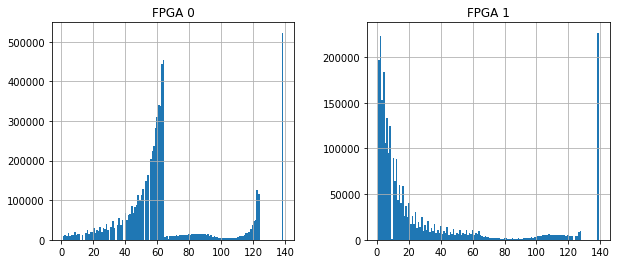

In [3]:
# Plot histogram
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

df_0 = data[data['FPGA']==0]
df_1 = data[data['FPGA']==1]

max_channel = data['TDC_CHANNEL'].max()
df_0.hist('TDC_CHANNEL', ax=ax1, bins=max_channel)#, range=(137,138))
df_1.hist('TDC_CHANNEL', ax=ax2, bins=max_channel)#, range=(137,138))
ax1.set_title('FPGA 0')
ax2.set_title('FPGA 1')

printmd(' ## HISTOGRAM OF HITS PER TDC CHANNEL <a id =1></a><br>')
printmd('Remark: There are a lot of hits falling under the mean time trigger channel: 139.')
plt.show()


# The difference between the channel distributions reflect the difference between the beams used in 
# the calibration run and the physics run. 
# Discontinuity and lesser amplitudes: shift in chamber

## HISTOGRAM (Calibration Run)

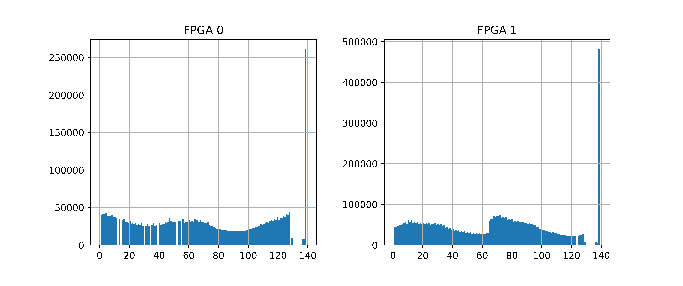

From observation, the distribution of hits in the calibration run is more "flat" as compared to the physics

In [4]:
printmd('## HISTOGRAM (Calibration Run)')
plt.figure(figsize = (12, 5))
calib_hist = plt.imread('histogram1.png')
#fig, ax = plt.subplots(figsize=(12, 6))
plt.imshow(calib_hist, aspect = 'auto')
plt.axis('off')
plt.show()

printmd('From observation, the distribution of hits in the calibration run is more "flat" as compared to the physics')

***
# II. ADDING NEW COLUMNS: TIME, DETECTOR, LAYER, AND CELL
 [Content Outline](#6)

## CONSTANTS: TRIGGER CHANNELS AND TMAX, L, Vd

In [5]:
st1 = 137  # Scintillator trigger channel 1
st2 = 138  # Scintillator trigger channel 2
mtt = 139  # Mean-time trigger channel
T_M = 390  #(maximum drift time in ns)
L = 42  # (lenght of the cell in mm)
v_d = L/(2*T_M)  # (constant drift velocity in mm/ns)

## TIME, DETECTOR, LAYER, AND CELL COLUMNS

In [6]:
# Time column
data['time'] = data['BX_COUNTER']*25 + data['TDC_MEAS']*25/30


In [7]:
# Define function to add the detector, layer and cell columns 

@vectorize([int64(int64, int64)])
def giveDetector(fpga, channel):
    if channel > 128:
        return -1

    channel -= 1
    return fpga*2 + 1 + channel // 64

@vectorize([int64(int64)])
def giveLayer(channel):
    if channel > 128:
        return -1

    layer_map = {0 : 1,
                 1 : 4,
                 2 : 2,
                 3 : 3}

    cell_index = channel % 64
    layer = layer_map[cell_index % 4]
    
    return layer

@vectorize([int64(int64)])
def giveCell(channel):
    if channel > 128:
        return -1

    channel -= 1
    cell_index = channel % 64
    cell = cell_index // 4 + 1

    return cell

# Test of functions(one particular layer and detector arrangement)
if __name__ == '__main__':
    first_cell_of_layer = 67
    a = np.arange(first_cell_of_layer,first_cell_of_layer+16*4,4)
    print(list(zip(giveDetector(0,a), giveLayer(a), giveCell(a))))

[(2, 3, 1), (2, 3, 2), (2, 3, 3), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 3, 7), (2, 3, 8), (2, 3, 9), (2, 3, 10), (2, 3, 11), (2, 3, 12), (2, 3, 13), (2, 3, 14), (2, 3, 15), (2, 3, 16)]


In [8]:
# Calculate the detector, layer & cell columns according to the previous functions
data['detector'] = giveDetector(data['FPGA'], data['TDC_CHANNEL'])
data['layer'] = giveLayer(data['TDC_CHANNEL'])
data['cell'] = giveCell(data['TDC_CHANNEL'])

printmd("Dataframe now has new columns: time, detector, layer, and cell.")
display(data.head(5))

Dataframe now has new columns: time, detector, layer, and cell.

,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time,detector,layer,cell
0,1,4,3838279555,2703,1,67575.833333,3,1,1
1,0,62,3838279555,2695,25,67395.833333,1,2,16
2,1,12,3838279555,2698,22,67468.333333,3,1,3
3,0,50,3838279555,2698,23,67469.166667,1,2,13
4,1,14,3838279555,2708,14,67711.666667,3,2,4


***
# III. FINDING EVENTS 
 [Content Outline](#6)

A trigger dataset is formed by applying a mask to the original data in order to isolate the hits that correspond to the TDC_CHANNEL 139. Similar lines of code are presented for the two other trigger channels, scintillator 1 and 2. 

In [9]:
trigger_mtt = data.loc[data['TDC_CHANNEL']==mtt, ['ORBIT_CNT','time']]
trigger_st = data.loc[(data['TDC_CHANNEL']==st1) | (data['TDC_CHANNEL']==st2), ['ORBIT_CNT','time']]


Using the .isin() function, the orbits found in trigger_mtt data is isolated from the original dataset to produce the 'events' dataset because, supposedly, **one event corresponds to one common orbit.** The next lines of code sorts the by orbits and reindexed to present the data for each event.

In [10]:

#.isin function compares the two arrays and takes only the orbits that are found in the trigger
events_mtt = data.loc[data['ORBIT_CNT'].isin(trigger_mtt['ORBIT_CNT'])]
events_st = data.loc[data['ORBIT_CNT'].isin(trigger_st['ORBIT_CNT'])]

def create_events(df):
    events = df.copy(deep=False)
    # We remove the events that are in channels above 128
    events = events[events['TDC_CHANNEL'] <= 128]

    # We now group by orbit
    events['event'] = events.groupby('ORBIT_CNT').ngroup()+1

    # Common orbits correspond to a single event
    events.set_index(['event', events.index], inplace=True) # We make the events column an index
    events.rename_axis(('event','index'), inplace=True)
    events.sort_values(['ORBIT_CNT','detector','layer','cell'], inplace=True) # We sort according to these categories
    
    return events

printmd('### Events in the Mean time Trigger <a id =2></a><br>')
events_mtt = create_events(events_mtt)
display(events_mtt.head(5))
if not trigger_st.empty:
    printmd('### Events in the Scintillator Trigger')
    events_st = create_events(events_st)
    display(events_st.head(5))

### Events in the Mean time Trigger <a id =2></a><br>

FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
event index                                                        
1     76        0            4  3838279555        3200        12   
      88        0           32  3838279555        3206        25   
      11        0           40  3838279555        2730        12   
      96        0           40  3838279555        3202        19   
      42        0           44  3838279555        2831        28   

                     time  detector  layer  cell  
event index                                       
1     76     80010.000000         1      1     1  
      88     80170.833333         1      1     8  
      11     68260.000000         1      1    10  
      96     80065.833333         1      1    10  
      42     70798.333333         1      1    11

***

# IV. FINDING TRAJECTORIES

In [11]:
def findTrajectories(df):
    data = df.copy(deep=False)
    data['t0_123'] = 0
    data['t0_234'] = 0
    for i in data.index.get_level_values(0).unique():
        present_detectors = data.loc[i,'detector'].unique()
        ev = data.loc[i].copy(deep=False)
        
        for det in present_detectors:
            sub_ev = ev.loc[ev['detector'] == det].copy(deep=False)
            for l in range(1,4):
                fst_layer = sub_ev.loc[sub_ev['layer'] == l, 'cell']
                sec_layer = sub_ev.loc[sub_ev['layer'] == l+1, 'cell']

                # Find successor for each cell in layer
                if l % 2 == 0:
                    successor_mask = fst_layer.isin(sec_layer) | fst_layer.isin(sec_layer+1)
                else:
                    successor_mask = fst_layer.isin(sec_layer) | fst_layer.isin(sec_layer-1)
                
                # Drop whole sub_event if the current layer is completely empty
                if successor_mask.sum() == 0:
                    sub_ev['t0_1'] = np.nan
                    sub_ev['t0_2'] = np.nan
                    break

                else:
                    # Drop rows where no successor was found
                    sub_ev.loc[(successor_mask==False).index, 't0_1'] = np.nan
                    sub_ev.loc[(successor_mask==False).index, 't0_2'] = np.nan

            na_mask = sub_ev['t0_1'].notna()
            if na_mask.sum() > 0:
                t_1 = sub_ev.loc[(sub_ev.loc[na_mask, 'layer']==1).index, 't0_1'].iloc[0]
                t_2 = sub_ev.loc[(sub_ev.loc[na_mask, 'layer']==2).index, 't0_1'].iloc[0]
                t_3 = sub_ev.loc[(sub_ev.loc[na_mask, 'layer']==3).index, 't0_1'].iloc[0]
                t_4 = sub_ev.loc[(sub_ev.loc[na_mask, 'layer']==4).index, 't0_1'].iloc[0]
                sub_ev.loc[na_mask,'t0_1'] = 0.5*(0.5*(t_1 + t_3) + t_2)
                sub_ev.loc[na_mask, 't0_2'] = 0.5*(0.5*(t_2 + t_4) + t_3)

    return data


# np.isin or in function of numpy/python is not supported by numba
# That's why we make a new .isin function to be able to use the @njit decorator
@njit
def myIsin(array_a, array_b):
    result = np.zeros(len(array_a), dtype=np.bool_)
    for i,a in enumerate(array_a):
        for j,b in enumerate(array_b):
            if a == b:
                result[i] = True
                break
    return result


@njit
def findTrajectories_np(data, inds, columns):
    det_ind, lay_ind, cel_ind, time_ind, t0_1_ind, t0_2_ind = columns #detector, layer, cel, time, 1t0, 2t0 are the columns
    #np.roll (array, shift, axis)  #elements of the input array are being shifted
    ev_locs = np.where(inds - np.roll(inds,1)!=0)[0]  #np.where(condition,[x,y]) return elements chosen from x or y depending on condition.
    ev_locs = np.append(ev_locs, [len(inds)])

    for i in range(len(ev_locs)-1):
    
        ev = data[ev_locs[i]:ev_locs[i+1]]

        # Every row registered in same detector?
        if np.unique(ev[:,det_ind]).size != 1:
            sub_ev_locs = np.where(ev[:,det_ind]-np.roll(ev[:,det_ind],1)!=0)[0]
            sub_ev_locs = np.append(sub_ev_locs, [len(ev[:,det_ind])])

        else:
            sub_ev_locs = np.array([0,len(ev[:,det_ind])])

        for j in range(len(sub_ev_locs)-1):
            sub_ev = ev[sub_ev_locs[j]:sub_ev_locs[j+1]]

            for l in range(1,4):
                fst_layer = sub_ev[sub_ev[:,lay_ind]==l,cel_ind]
                sec_layer = sub_ev[sub_ev[:,lay_ind]==l+1,cel_ind]

                # Find successor for each cell in layer
                if l % 2 == 0:
                    successor_mask = myIsin(fst_layer, sec_layer) | myIsin(fst_layer, sec_layer+1)
                else:
                    successor_mask = myIsin(fst_layer, sec_layer) | myIsin(fst_layer, sec_layer-1)

                # Drop whole sub_event if the current layer is completely empty
                if np.any(successor_mask) == False:
                    sub_ev[:,t0_1_ind] = np.nan
                    sub_ev[:,t0_2_ind] = np.nan
                    break

                # Else mark rows where no predecessor was found
                # if one cell was found with no predecessor
                elif np.all(successor_mask) == False: # False has to be np.array([False]) so that numba broadcasts
                    idx = np.nonzero(successor_mask==np.array([False]))[0] + np.nonzero(sub_ev[:,lay_ind]==l)[0][0]
                    sub_ev[idx,t0_1_ind] = np.nan
                    sub_ev[idx,t0_2_ind] = np.nan

            # Compute t0 if a trajectory was found
            mask = ~np.isnan(sub_ev[:,t0_1_ind]) # mask where values are numbers and not NaN
            if np.any(mask) == True:
                t_1 = sub_ev[sub_ev[mask,lay_ind]==1,time_ind][0]
                t_2 = sub_ev[sub_ev[mask,lay_ind]==2,time_ind][0]
                t_3 = sub_ev[sub_ev[mask,lay_ind]==3,time_ind][0]
                t_4 = sub_ev[sub_ev[mask,lay_ind]==4,time_ind][0]
                sub_ev[mask,t0_1_ind] = 0.5*(0.5*(t_1 + t_3) + t_2 - T_M)
                sub_ev[mask,t0_2_ind] = 0.5*(0.5*(t_2 + t_4) + t_3 - T_M)

    return data


## Computing $t_0$

In [12]:
def calculate_t0(df):
    events = df.copy(deep=False)

    events['t0_123'] = 0
    events['t0_234'] = 0
    level0_inds = events.index.get_level_values(0).to_numpy()
    c_names = ['detector', 'layer', 'cell', 'time', 't0_123', 't0_234']
    columns = np.array([events.columns.get_loc(column) for column in c_names])

    data = findTrajectories_np(events.to_numpy(), level0_inds, columns)
    events = pd.DataFrame(data=data, index=events.index, columns=events.columns)

    events['detector'] = events['detector'].astype(np.int32)
    events['layer'] = events['layer'].astype(np.int32)
    events['cell'] = events['cell'].astype(np.int32)

    return events

printmd("### $t_0$ for Mean Time Trigger")
events_mtt = calculate_t0(events_mtt)
display(events_mtt.head(5))
if not trigger_st.empty:
    printmd("### $t_0$ for Scintillator Trigger")
    events_st = calculate_t0(events_st)
    display(events_st.head(5))

### $t_0$ for Mean Time Trigger

FPGA  TDC_CHANNEL     ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
event index                                                          
1     76      0.0          4.0  3.838280e+09      3200.0      12.0   
      88      0.0         32.0  3.838280e+09      3206.0      25.0   
      11      0.0         40.0  3.838280e+09      2730.0      12.0   
      96      0.0         40.0  3.838280e+09      3202.0      19.0   
      42      0.0         44.0  3.838280e+09      2831.0      28.0   

                     time  detector  layer  cell     t0_123     t0_234  
event index                                                             
1     76     80010.000000         1      1     1        NaN        NaN  
      88     80170.833333         1      1     8        NaN        NaN  
      11     68260.000000         1      1    10  76573.125  73416.875  
      96     80065.833333         1      1    10  76573.125  73416.875  
      42     70798.333333         1      1    11  76573.125  73416.875

***
# V. CHARACTERIZING THE EVENTS
 [Content Outline](#6)
## CALCULATION OF DRIFT TIMES

#### For the Mean time Trigger

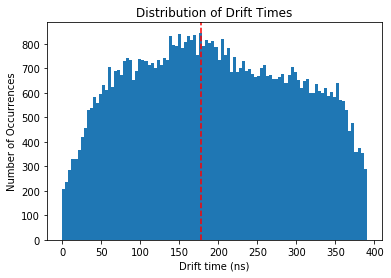

In [13]:
def make_hist(df):
    events = df.copy(deep=False)

    #  Check if t0_123 & t0_234 are "reasonable close" to each other, if they are compute average
    mask = np.abs(events['t0_123'] - events['t0_234']) < T_M/4
    events.loc[mask, 't0'] = (events['t0_123'] + events['t0_234'])/2
    events.loc[~mask, 't0'] = np.nan

    #  Optionally drop t0_123 and t0_234
    events.drop(['t0_123', 't0_234'], inplace=True, axis=1)

    #  Compute drift time and position
    events['drift_time'] = events['time'] - events['t0']
    events['x'] = v_d*events['drift_time']

    #  Clean up data for events which have a negative drift time or a position over 21mm
    events.loc[(events['drift_time']<0) | (events['x']>L/2), 't0'] = np.nan

    hist, edges,_ = plt.hist(events.loc[events['t0'].notna(), 'drift_time'], bins=100)
    mid_edges = (edges[:-1] + edges[1:])/2

    plt.title('Distribution of Drift Times')
    plt.axvline(mid_edges[np.argmax(hist)], c='r', ls='--')
    plt.xlabel('Drift time (ns)')
    plt.ylabel('Number of Occurrences')

    plt.show()

    return events


printmd('#### For the Mean time Trigger')    
events_mtt = make_hist(events_mtt)
if not trigger_st.empty:
    printmd('#### For the Scintillator Trigger')    
    events_st = make_hist(events_st)

#### Drift Times (Calibration Run)  <a id =3></a><br>

Both the calibration run and physics run show similar behavior: a maximum around 200 ns.

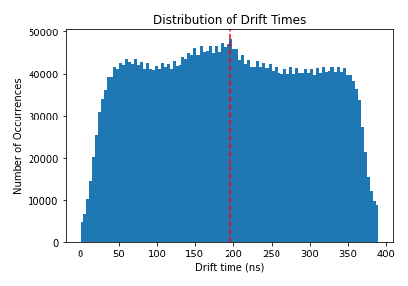

In [14]:
printmd('#### Drift Times (Calibration Run)  <a id =3></a><br>')
printmd('Both the calibration run and physics run show similar behavior: a maximum around 200 ns.')
plt.figure(figsize = (12, 5))
calib_hist = plt.imread('drift_mtt.png')
#fig, ax = plt.subplots(figsize=(12, 6))
plt.imshow(calib_hist)
plt.axis('off')
plt.show()

## FILTERING THE DATA

In [15]:
def print_useful_events(df):
    events = df.copy(deep=False)

    # Ratio of "useful rows" to all rows
    try:
        print('"useful rows" / "all rows": ', 1 - len(events[events['t0'].isna()])/events.shape[0])
    except ZeroDivisionError:
        print('Error: Dataframe is empty')

    #  Event is counted as useful if 4 or more times are available
    event_groups = events.loc[events['t0'].notna(),'time'].groupby('event').count()
    # print(event_groups) 
    try:
        print('"useful events" / "all events"', (event_groups>3).sum()/len(event_groups))  # some events only have 3 (or below) hits
    except ZeroDivisionError:
        print('Error: Dataframe is empty')

printmd('### Useful Events <a id =5></a><br>')
print('Mean Time Trigger (Physics Run):')
print_useful_events(events_mtt)
print('\n Mean Time Trigger (Calibration Run):')
print('"useful rows" / "all rows":  0.7248652838992968')
print('"useful events" / "all events" 0.9690319274265875')
printmd('Remark: There is less useful hits in the Physics Run.')

if not trigger_st.empty:
    print('\n','Scintillator Trigger')
    print_useful_events(events_st)

### Useful Events <a id =5></a><br>

Mean Time Trigger (Physics Run):
"useful rows" / "all rows":  0.007690596077508771
"useful events" / "all events" 0.9319010544988666

 Mean Time Trigger (Calibration Run):
"useful rows" / "all rows":  0.7248652838992968
"useful events" / "all events" 0.9690319274265875


Remark: There is less useful hits in the Physics Run.

### Now we filter the data with the following criteria
1. Drop hits that do not align
2. Obtain events that have at least one hit per layer (i.e. 4 layer representation)
3. Sort out events that have only one detector representation

In [16]:
def prepare_for_vis(df):
    # Drop all not aligning hits
    visual_evs = df.dropna(subset = ['t0']).copy() 
    
    #  Sort out events which do not go through each layer for each present detector 
    go_through_each_lay = (visual_evs.loc[:,['layer','detector']].groupby(['event','detector']).nunique() == 4).loc[:,'layer']
    go_through_each_lay = go_through_each_lay.groupby('event').all()
    
    #  Sort out events which are only registered in one detector
    multiple_detectors = visual_evs.loc[:,'detector'].groupby('event').nunique() > 1
    
    #  Combine the two masks
    index_mask = go_through_each_lay & multiple_detectors

    #  Apply mask to the dataframe
    visual_evs = visual_evs.loc[visual_evs.index.get_level_values(0).map(index_mask),:]

    #  Reindex the event index level starting from 1
    visual_evs.reset_index(level='event', inplace=True)
    visual_evs.loc[:,'event'] = (visual_evs.loc[:,'event'].diff()!=0).cumsum()
    visual_evs.set_index(['event', visual_evs.index], inplace=True)
    
    return visual_evs


events_mtt_vis = prepare_for_vis(events_mtt)
printmd('### Event 1 for the Mean time Trigger')
display(events_mtt_vis.head(8))
if not trigger_st.empty:
    events_st_vis = prepare_for_vis(events_st)
    printmd('### Event 1 for the Scintillator Trigger')
    display(events_st_vis.head(8))

### Event 1 for the Mean time Trigger

FPGA  TDC_CHANNEL     ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
event index                                                          
1     24562   0.0          8.0  3.838280e+09      1382.0       5.0   
      24557   0.0          6.0  3.838280e+09      1375.0      29.0   
      24559   0.0          7.0  3.838280e+09      1379.0      13.0   
      24561   0.0          5.0  3.838280e+09      1382.0      28.0   
      24547   0.0         76.0  3.838280e+09       843.0      24.0   
      24544   0.0         74.0  3.838280e+09       842.0      21.0   
      24545   0.0         86.0  3.838280e+09       844.0      25.0   
      24550   0.0         83.0  3.838280e+09       851.0      21.0   

                     time  detector  layer  cell          t0  drift_time  \
event index                                                                
1     24562  34554.166667         1      1     2  34277.8125  276.354167   
      24557  34399.166667         1      2     2  34277.8125  121.354167   
      24559  34485.833333         1      3     2  34277.8125  208.020833   
      24561  34573.333333         1      4     2  34277.8125  295.520833   
      24547  21095.000000         2      1     3  20909.6875  185.312500   
      24544  21067.500000         2      2     3  20909.6875  157.812500   
      24545  21120.833333         2      2     6  20909.6875  211.145833   
      24550  21292.500000         2      3     5  20909.6875  382.812500   

                     x  
event index             
1     24562  14.880609  
      24557   6.534455  
      24559  11.201122  
      24561  15.912660  
      24547   9.978365  
      24544   8.497596  
      24545  11.369391  
      24550  20.612981

***
# <a id =4></a><br> VI. THE DETECTOR MATRIX 
 [Content Outline](#6)
 

The following paths represent some of the event trajectories found in the data. <span style='color:blue'> Blue </span> dots indicate paths at the right of the anodic wire, while <span style='color:green'> green </span> dots indicate paths at the left as in the project description

#### Event Path 1

This event follows a trajectory of a particle through detectors 1 and 2.

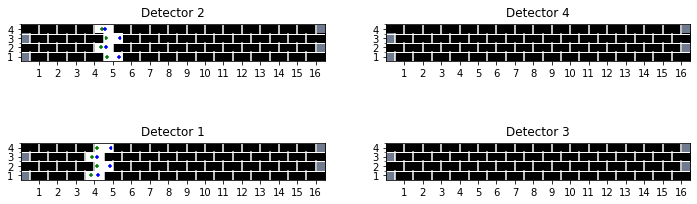

#### Event Path 2

This event follows a trajectory of a particle through detectors 3 and 4.

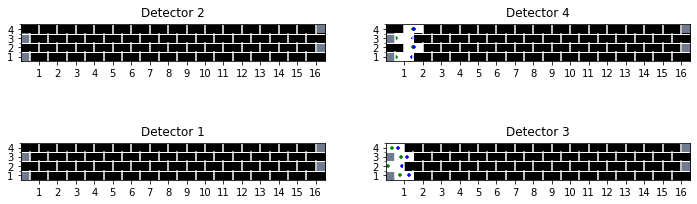

#### Event Path 3

Like in the Calibration run, we get these noisy trajectories. It is noticeable that we get these erratic trajectories much more common in the physics run.

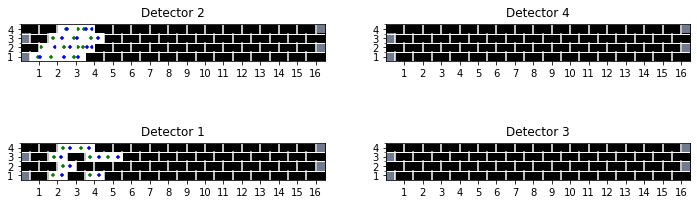

In [17]:
def plotDetector(ax, event, is_empty):
    detector = np.zeros((4,16*2+1))

    even_layers = event['layer']%2 == 0
    odd_layers = even_layers == False

    def fillDetectorMatrix(matrix, i, j, s=0):
        matrix[i,j*2+s] = 1
        matrix[i,j*2+1+s] = 1

    def plotLeftRight(ax, cell, position, layer, odd, left):
        if left == True:
            ax.scatter((cell-1-position/L)*2+0.5+odd, layer-1, s=10, c='g', marker='+')
        else:
            ax.scatter((cell-1+position/L)*2+0.5+odd, layer-1, s=10, c='b', marker='+')
    
    if is_empty == False:
        fillDetectorMatrix(detector, event.loc[even_layers,'layer']-1,
                    event.loc[even_layers,'cell']-1, s=0)
        fillDetectorMatrix(detector, event.loc[odd_layers,'layer']-1,
                    event.loc[odd_layers,'cell']-1, s=1)

        for odd,left in [[odd, left] for odd in [True, False] for left in [True,False]]:
            if odd == True:
                layers = odd_layers
            else:
                layers = even_layers

            plotLeftRight(ax, event.loc[layers, 'cell'], event.loc[layers, 'x'],
                     event.loc[layers, 'layer'], odd, left)

    detector[(0,1,2,3),(0,32,0,32)] = 0.5 # Mark "cell offset"
    ax.matshow(detector, origin='lower', cmap='bone', vmin=0, vmax=1)

    # Major ticks
    ax.set_xticks(np.arange(1.5, 32, 2));
    ax.set_yticks(np.arange(0, 4, 1));

    # # Labels for major ticks
    ax.set_xticklabels(np.arange(1, 17, 1));
    ax.set_yticklabels(np.arange(1, 5, 1));

    # # Minor ticks
    # # ax.set_xticks(np.arange(-.5, 32, 2), minor=True);
    ax.set_yticks(np.arange(0.5, 4, 1), minor=True);

    ax.grid(which='minor', axis='y', color='w', linewidth=1)
    ax.xaxis.set_ticks_position('bottom')
    
    vert_line = np.array([0,1])
    for l in range(4):
        for c in range(16):
            if l%2 == 0:
                ax.plot([c*2+0.5,c*2+0.5], vert_line+l-0.5, c='w')
            else:
                ax.plot([c*2+1.5,c*2+1.5], vert_line+l-0.5, c='w')

def plotEvent(event):
    fig, axes = plt.subplots(2, 2, figsize=(12,4))

    for i in range(0,4):
        sub_ev = event.loc[event['detector']==i+1, :]
        plotDetector(axes[1-i%2,i//2], sub_ev, sub_ev.empty)
        axes[1-i%2,i//2].set_title('Detector {}'.format(i+1))
    # TODO legend

    plt.show()


printmd("The following paths represent some of the event trajectories found in the data. <span style='color:blue'> Blue </span> dots indicate paths at the right of the anodic wire, while <span style='color:green'> green </span> dots indicate paths at the left as in the project description")
printmd("#### Event Path 1")
printmd("This event follows a trajectory of a particle through detectors 1 and 2.")
plotEvent(events_mtt_vis.loc[11])

printmd("#### Event Path 2")
printmd("This event follows a trajectory of a particle through detectors 3 and 4.")
plotEvent(events_mtt_vis.loc[273])

printmd("#### Event Path 3")
printmd("Like in the Calibration run, we get these noisy trajectories. It is noticeable that we get these erratic trajectories much more common in the physics run.")
plotEvent(events_mtt_vis.loc[116])

#### Final Remarks: 
The Physics Run showed more noise in the data. Nonetheless, the code that was done for the calibration run still worked well.